**IMPORTING LIBRARIES**

In [ ]:
import spacy as sp
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from nltk.tokenize import sent_tokenize

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,SpatialDropout1D
from tensorflow.keras import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
import numpy as np

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

**HANDLING DATASET**

In [ ]:
df=pd.read_csv('spam.csv', encoding='latin1')

In [ ]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
df=df[['v1','v2']]

In [ ]:
df.rename(columns={'v1':'label', 'v2':'message'}, inplace=True)

<ipython-input-121-13acc4757117>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'v1':'label', 'v2':'message'}, inplace=True)


In [ ]:
df

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
df.groupby('label').describe()


message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

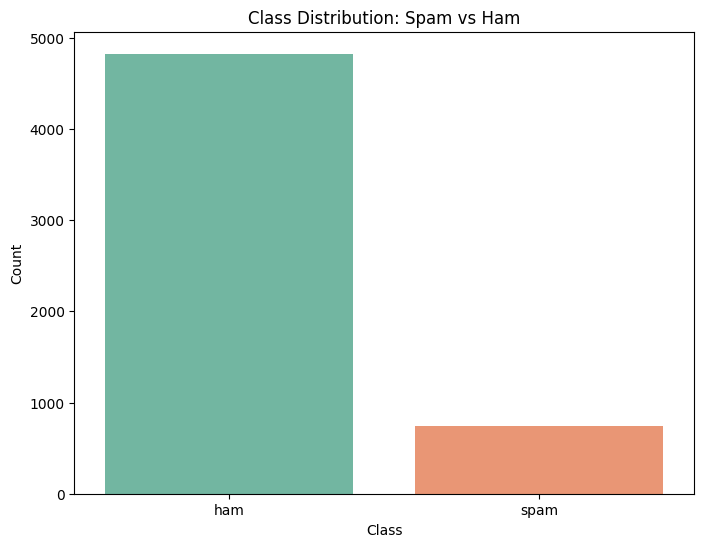

In [ ]:
class_counts = df['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title('Class Distribution: Spam vs Ham')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

**PREPROCESSING TEXT**

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

for index, row in df.iterrows():
    text = row['message']
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and not token in stop_words]  # Lemmatize,filter out non-alphabetic tokens,remove stopwords
    data= " ".join(tokens)
    df.at[index, 'processed__text'] = data


<ipython-input-126-81d433f709ae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, 'processed__text'] = data


In [ ]:
df.describe()

,label,message,processed__text
count,5572,5572,5572
unique,2,5169,5034
top,ham,"Sorry, I'll call later",sorry call later
freq,4825,30,30


In [ ]:
df['msg_type'] = df['label'].map({'ham':0, 'spam':1})
df['len']=df['processed__text'].apply(len)


<ipython-input-128-e18810767810>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['msg_type'] = df['label'].map({'ham':0, 'spam':1})


In [ ]:
df

,label,message,processed__text,msg_type,len
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,0,82
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0,23
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts may...,1,98
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say,0,35
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though,0,35
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,time tried contact u pound prize claim easy ca...,1,59
5568,ham,Will Ì_ b going to esplanade fr home?,b going esplanade fr home,0,25
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood suggestion,0,20
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like interested buying some...,0,78


**LSTM**

In [ ]:
X = df['processed__text']## independent variable
Y = df['msg_type']## target variable
#le = LabelEncoder()
#Y = le.fit_transform(Y) ## converting categorical into numerical
#Y = Y.reshape(-1,1) ## 1 column to use for neural network

In [ ]:
#print(le.classes_)

['ham' 'spam']


In [ ]:
#print(Y)

[[0]
 [0]
 [1]
 ...
 [0]
 [0]
 [0]]


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15) ## splitting into test train


In [ ]:
max_words = 1000 ## maximum number of words in the vocabulary that will be considered during tokenization.
max_len = 150 ## specifies the maximum length of the sequences after tokenization and padding. shorter add 0s as pad, greater truncate
tok = Tokenizer(num_words=max_words) ## preprocess making sure only most frequent words are used
tok.fit_on_texts(X_train) ## fit tokenizer on train data
sequences = tok.texts_to_sequences(X_train) ## convert the text data into sequences of integer indices. each sequence reps each sent, each word reps by iinteger index
sequences_matrix = pad_sequences(sequences,maxlen=max_len) ## ensure all sents have same length either by truncating or padding

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len]) ## input layer,specifies the shape of the input data.the input data will be sequences of integers, each of length max_len.
    layer = Embedding(max_words,50,input_length=max_len)(inputs)## embedding layer, convert to dense vector of fixed size 50
    layer = LSTM(64)(layer) ## LSTM layer to capture sequential dependencies
    layer = Dense(256,name='FC1')(layer) ## fully conn Dense Layer, 256 neurons
    layer = Activation('relu')(layer) ## applying activation func to previous dense layer
    layer = Dropout(0.5)(layer) ## dropout layer to avoid overfitting
    layer = Dense(1,name='out_layer')(layer) ## output layer with 1 neuron,single output value for binary classification.
    layer = Activation('sigmoid')(layer) ## applying activation func to previous dense layer
    model = Model(inputs=inputs,outputs=layer) ## final model specifying input and output layer after all transformations
    return model

In [ ]:
model = RNN() ## instance of the RNN model.
model.summary() ## summary of the model's architecture
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy','Recall','Precision']) ## configure the model for training, specifies the loss function,specifies the optimizer to be used during training, specifies the evaluation metrics

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_6 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, ##input data for training,target data,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]) ## 20% of the training data will be used for validation during training.


Epoch 1/10
30/30 [==============================] - 13s 353ms/step - loss: 0.3438 - accuracy: 0.8675 - recall: 0.0808 - precision: 0.4598 - val_loss: 0.2113 - val_accuracy: 0.9684 - val_recall: 0.7970 - val_precision: 0.9725
Epoch 2/10
30/30 [==============================] - 8s 272ms/step - loss: 0.1164 - accuracy: 0.9699 - recall: 0.8020 - precision: 0.9613 - val_loss: 0.0618 - val_accuracy: 0.9800 - val_recall: 0.8872 - val_precision: 0.9672
Epoch 3/10
30/30 [==============================] - 7s 241ms/step - loss: 0.0640 - accuracy: 0.9807 - recall: 0.8970 - precision: 0.9528 - val_loss: 0.0556 - val_accuracy: 0.9821 - val_recall: 0.9098 - val_precision: 0.9603
Epoch 4/10
30/30 [==============================] - 9s 287ms/step - loss: 0.0455 - accuracy: 0.9852 - recall: 0.9273 - precision: 0.9582 - val_loss: 0.0534 - val_accuracy: 0.9884 - val_recall: 0.9398 - val_precision: 0.9766
Epoch 5/10
30/30 [==============================] - 8s 275ms/step - loss: 0.0375 - accuracy: 0.9884 - r

In [ ]:
test_sequences = tok.texts_to_sequences(X_test) ## converts the test text data into sequences of integer indices using the same tokenizer (tok) that was used for the training data,processed text data to evaluate using the trained model.
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len) ## padding

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test) ##  assess its performance on the provided test data.


27/27 [==============================] - 1s 22ms/step - loss: 0.0701 - accuracy: 0.9809 - recall: 0.9076 - precision: 0.9558


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}\n  Recall: {:0.3f}\n  Precision: {:0.3f}'.format(accr[0], accr[1], accr[2], accr[3]))


Test set
  Loss: 0.070
  Accuracy: 0.981
  Recall: 0.908
  Precision: 0.956


In [ ]:
new_complaint = ['''
'''
]

seq = tok.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)

1/1 [==============================] - 0s 28ms/step


In [ ]:
predicted_probability = pred[0][0] # Extract the predicted probability from the prediction array

if predicted_probability > 0.8:
    predicted_label = "spam"
else:
    predicted_label = "ham"

print("Predicted Probability:", predicted_probability)
print("Predicted Label:", predicted_label)

Predicted Probability: 0.0064161997
Predicted Label: ham
